<a href="https://colab.research.google.com/github/csch7/CSCI-4170/blob/main/Homework-06/Recommender-Systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import drive

drive.mount('/content/drive')

train = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/u1.base', dtype=np.uint32)
test = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/u1.test', dtype=np.uint32)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


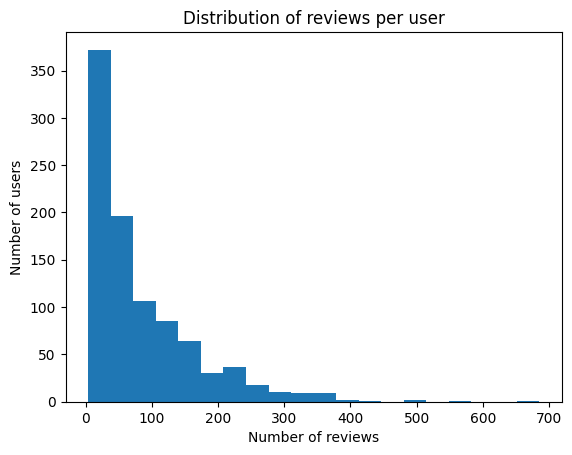

In [2]:
num_reviews = np.unique(train[:,0], return_counts=True)[1]
plt.hist(num_reviews, bins = 20)
plt.title("Distribution of reviews per user")
plt.ylabel("Number of users")
plt.xlabel("Number of reviews")
plt.show()

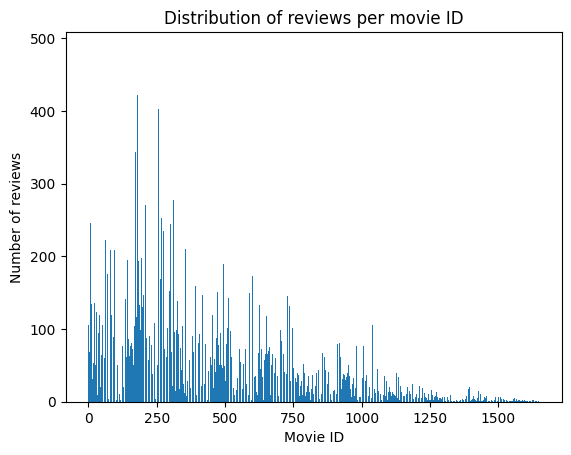

In [3]:
num_reviews = np.unique(train[:,1], return_counts=True)[1]
plt.bar(np.arange(len(num_reviews)), num_reviews)
plt.title("Distribution of reviews per movie ID")
plt.ylabel("Number of reviews")
plt.xlabel("Movie ID")
plt.show()

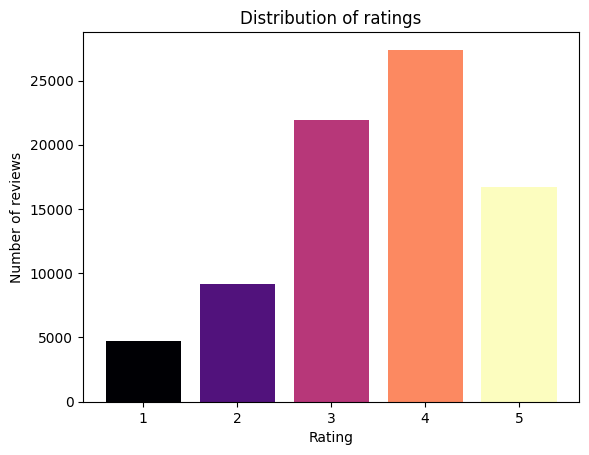

In [4]:
import matplotlib
cmap = matplotlib.colormaps['magma']

colors = [matplotlib.colors.to_hex(cmap(i)) for i in np.linspace(0, 1, 5)]

num_reviews = np.unique(train[:,2], return_counts=True)[1]
plt.bar(np.arange(1,6), num_reviews, color=colors)
plt.title("Distribution of ratings")
plt.ylabel("Number of reviews")
plt.xlabel("Rating")
plt.show()

In [5]:

uim = np.zeros((len(np.unique(train[:,0])), max(train[:,1])))

for i in range(len(np.unique(train[:,0]))):
  uim[train[i,0]-1, train[i,1]-1] = train[i,2]


## Matrix Factorization:

In [6]:
from scipy.sparse.linalg import svds

uim = uim-np.mean(uim)

u, s, vt = svds(uim, k=10)

predicted_ratings = np.dot(np.dot(u, np.diag(s)), vt)
print(predicted_ratings)

[[ 4.99183974e+00  2.99701916e+00  3.99659521e+00 ... -1.70896947e-03
  -1.70896947e-03 -1.70896947e-03]
 [ 3.90403349e+00 -6.26154083e-03 -7.68888840e-03 ... -1.97949810e-03
  -1.97949810e-03 -1.97949810e-03]
 [ 3.37581720e-01  4.89171747e-02  6.53844947e-02 ... -4.84785248e-04
  -4.84785248e-04 -4.84785248e-04]
 ...
 [-3.45106452e-03 -7.44296155e-04 -9.93688025e-04 ...  3.87945831e-06
   3.87945831e-06  3.87945831e-06]
 [-3.45106452e-03 -7.44296155e-04 -9.93688025e-04 ...  3.87945831e-06
   3.87945831e-06  3.87945831e-06]
 [-3.45106452e-03 -7.44296155e-04 -9.93688025e-04 ...  3.87945831e-06
   3.87945831e-06  3.87945831e-06]]


In [37]:
from torch import nn
import torch


class NCF(nn.Module):
  def __init__(self, n_movies, n_users, embed_dim = 16, hidden_layers = 4, hidden_size = 32):
    super().__init__()
    self.user_embed_mlp = nn.Linear(n_users, embed_dim)
    self.user_embed_gmf = nn.Linear(n_users, embed_dim)
    self.movie_embed_mlp = nn.Linear(n_movies, embed_dim)
    self.movie_embed_gmf = nn.Linear(n_movies, embed_dim)

    self.MLP = nn.Sequential(
        nn.Linear(2*embed_dim, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size//2)
    )
    self.neumf = nn.Linear(hidden_size, 1)
    self.out = nn.Hardsigmoid()

  def forward(self, u, m):
    u_emb_mlp = self.user_embed_mlp(u)
    u_emb_gmf = self.user_embed_gmf(u)
    m_emb_mlp = self.movie_embed_mlp(m)
    m_emb_gmf = self.movie_embed_gmf(m)

    gmf = torch.mul(u_emb_gmf, m_emb_gmf)

    mlp = self.MLP(torch.cat((u_emb_mlp, m_emb_mlp), dim=1))

    return self.out(self.neumf(torch.cat((gmf, mlp), dim=1)))


In [42]:
t_dict = {k:[int(train[i,1]) for i in range(len(train)) if train[i,0] == k] for k in set(train[:,0])}
test_dict = {k:[int(test[i,1]) for i in range(len(test)) if test[i,0] == k] for k in set(test[:,0])}

In [34]:
M = max(train[:,1])
U = len(np.unique(train[:,0]))


def ohe(t_dict, b, batch_size):
  users_ohe = np.zeros((batch_size, U))
  movies_ohe = np.zeros((batch_size, M))
  ratings_ohe = np.zeros((batch_size, 1))
  for r in range(b*batch_size, (b+1)*batch_size):
    i = r - b*batch_size
    users_ohe[i, r//M] = 1
    movies_ohe[i, r%M] = 1
    if r%M+1 in t_dict[r//M+1]:
      ratings_ohe[i,0] = 1
  return torch.Tensor(users_ohe), torch.Tensor(movies_ohe), torch.Tensor(ratings_ohe)


In [49]:
from torch import optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score


model = NCF(max(train[:,1]), len(np.unique(train[:,0])))
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
epochs = 2
batch_size = 1024
N = train.shape[0]

for e in range(epochs):
  model.train()
  losses = []
  for b in tqdm(range(U*M//batch_size)):
    optimizer.zero_grad()
    u_batch, m_batch, r_batch = ohe(t_dict, b, batch_size)

    pred = model(u_batch, m_batch)
    loss = loss_fn(pred, r_batch)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
  print("Epoch {} | Loss: {:.5f}".format(e, np.mean(losses)))

model.eval()
with torch.no_grad():
  u, m, r = ohe(test_dict, 0, len(test))
  pred = torch.round(model(u, m))
  print(torch.sum(pred))
  print(accuracy_score(pred, r))



100%|██████████| 1548/1548 [00:56<00:00, 27.46it/s]


Epoch 0 | Loss: 0.40252


100%|██████████| 1548/1548 [00:54<00:00, 28.16it/s]


Epoch 1 | Loss: 0.30243
tensor(85.)
0.9582
